# 07. Model Training

### Importando as bibliotecas

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions.fn_stats as fn_stats
import functions.fn_charts as fn_charts
import params.consts as consts
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer,)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline # Usando o pipeline do imblearn pois esse é um dataset desbalanceado
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

### Lendo o dataset tratado e visualizando o overview atual

In [2]:
df = pd.read_csv(consts.CLUSTERED_DATASET) # Armazenando o dataset tratado em uma variável

df # Exbindo uma visão geral do dataset

,Education,Marital_Status,Children,HasChildren,Age,AgeGroup,Income,Recency,Complain,Days_Since_Enrolled,...,NumDealsPurchases,NumWebVisitsMonth,NumTotalPurchases,MntRegularProds,MntGoldProds,MntTotal,AcceptedCmpTotal,HasAcceptedCmp,Response,Cluster
0,Graduation,Single,0,0,57,46-60,58138.0,58,0,663,...,3,7,22,1529,88,1617,0,0,1,2
1,Graduation,Single,2,1,60,46-60,46344.0,38,0,113,...,2,5,4,21,6,27,0,0,0,1
2,Graduation,Partner,0,0,49,46-60,71613.0,26,0,312,...,1,4,20,734,42,776,0,0,0,0
3,Graduation,Partner,1,1,30,18-30,26646.0,26,0,139,...,2,6,6,48,5,53,0,0,0,1
4,PhD,Partner,1,1,33,31-45,58293.0,94,0,161,...,5,5,14,407,15,422,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,Graduation,Partner,1,1,47,46-60,61223.0,46,0,381,...,2,5,16,1094,247,1341,0,0,0,2
2201,PhD,Partner,3,1,68,61+,64014.0,56,0,19,...,7,7,15,436,8,444,1,1,0,2
2202,Graduation,Single,0,0,33,31-45,56981.0,91,0,155,...,1,6,18,1217,24,1241,1,1,0,0
2203,Master,Partner,1,1,58,46-60,69245.0,8,0,156,...,2,3,21,782,61,843,0,0,0,2


In [3]:
df.info() # Exibindo as informações das variáveis do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2205 non-null   object 
 1   Marital_Status        2205 non-null   object 
 2   Children              2205 non-null   int64  
 3   HasChildren           2205 non-null   int64  
 4   Age                   2205 non-null   int64  
 5   AgeGroup              2205 non-null   object 
 6   Income                2205 non-null   float64
 7   Recency               2205 non-null   int64  
 8   Complain              2205 non-null   int64  
 9   Days_Since_Enrolled   2205 non-null   int64  
 10  Years_Since_Enrolled  2205 non-null   int64  
 11  NumDealsPurchases     2205 non-null   int64  
 12  NumWebVisitsMonth     2205 non-null   int64  
 13  NumTotalPurchases     2205 non-null   int64  
 14  MntRegularProds       2205 non-null   int64  
 15  MntGoldProds         

In [4]:
fn_stats.describe(df) # Usando a função que exibe as estatísticas das colunas numéricas

,Children,HasChildren,Age,Income,Recency,Complain,Days_Since_Enrolled,Years_Since_Enrolled,NumDealsPurchases,NumWebVisitsMonth,NumTotalPurchases,MntRegularProds,MntGoldProds,MntTotal,AcceptedCmpTotal,HasAcceptedCmp,Response,Cluster
count,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00
mean,0.95,0.72,45.10,51622.09,49.01,0.01,353.72,0.48,2.32,5.34,12.57,562.76,44.06,606.82,0.30,0.21,0.15,1.09
std,0.75,0.45,11.71,20713.06,28.93,0.09,202.56,0.50,1.89,2.41,7.18,575.94,51.74,601.68,0.68,0.41,0.36,0.76
min,0.00,0.00,18.00,1730.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,5.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,37.00,35196.00,24.00,0.00,180.00,0.00,1.00,3.00,6.00,56.00,9.00,69.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,44.00,51287.00,49.00,0.00,356.00,0.00,2.00,6.00,12.00,343.00,25.00,397.00,0.00,0.00,0.00,1.00
75%,1.00,1.00,55.00,68281.00,74.00,0.00,529.00,1.00,3.00,7.00,18.00,964.00,56.00,1047.00,0.00,0.00,0.00,2.00
max,3.00,1.00,74.00,113734.00,99.00,1.00,699.00,1.00,15.00,20.00,32.00,2491.00,321.00,2525.00,4.00,1.00,1.00,2.00


In [5]:
df.describe(exclude='number') # Exibindo as estatísticas das colunas categóricas

,Education,Marital_Status,AgeGroup
count,2205,2205,2205
unique,5,2,4
top,Graduation,Partner,31-45
freq,1113,1422,958


In [6]:
df.isnull().sum() # Somando todos os valores nulos de cada coluna

Education               0
Marital_Status          0
Children                0
HasChildren             0
Age                     0
AgeGroup                0
Income                  0
Recency                 0
Complain                0
Days_Since_Enrolled     0
Years_Since_Enrolled    0
NumDealsPurchases       0
NumWebVisitsMonth       0
NumTotalPurchases       0
MntRegularProds         0
MntGoldProds            0
MntTotal                0
AcceptedCmpTotal        0
HasAcceptedCmp          0
Response                0
Cluster                 0
dtype: int64

### Definindo os valores de x e y para o modelo de classificação definido

In [7]:
x = df.drop('Response', axis=1) # Definindo os valores de x para o modelo, separando a variável target do dataset
y = df['Response'] # Definindo os valores de y para o modelo, deixando o dataset somente com a variável target

In [8]:
x.head(3) # Visualizando os dados de x

,Education,Marital_Status,Children,HasChildren,Age,AgeGroup,Income,Recency,Complain,Days_Since_Enrolled,Years_Since_Enrolled,NumDealsPurchases,NumWebVisitsMonth,NumTotalPurchases,MntRegularProds,MntGoldProds,MntTotal,AcceptedCmpTotal,HasAcceptedCmp,Cluster
0,Graduation,Single,0,0,57,46-60,58138.0,58,0,663,1,3,7,22,1529,88,1617,0,0,2
1,Graduation,Single,2,1,60,46-60,46344.0,38,0,113,0,2,5,4,21,6,27,0,0,1
2,Graduation,Partner,0,0,49,46-60,71613.0,26,0,312,0,1,4,20,734,42,776,0,0,0


In [9]:
y.head(3) # Visualizando os dados de y

0    1
1    0
2    0
Name: Response, dtype: int64

### Listando as variáveis numéricas e categóricas de x

In [10]:
numerical_features = x.select_dtypes(include='number').columns # Armazenando as features numéricas em uma variável
categorical_features = x.select_dtypes(exclude='number').columns # Armazenando as features categóricas em uma variável

print('- Numerical Features:') # Printando as variávei numéricas
for feature in numerical_features:
    print(feature)

print('\n- Categorical Features:') # Printando as variávei categóricas
for feature in categorical_features:
    print(feature)

- Numerical Features:
Children
HasChildren
Age
Income
Recency
Complain
Days_Since_Enrolled
Years_Since_Enrolled
NumDealsPurchases
NumWebVisitsMonth
NumTotalPurchases
MntRegularProds
MntGoldProds
MntTotal
AcceptedCmpTotal
HasAcceptedCmp
Cluster

- Categorical Features:
Education
Marital_Status
AgeGroup


### Visualizando a distribuição das features de x em histogramas

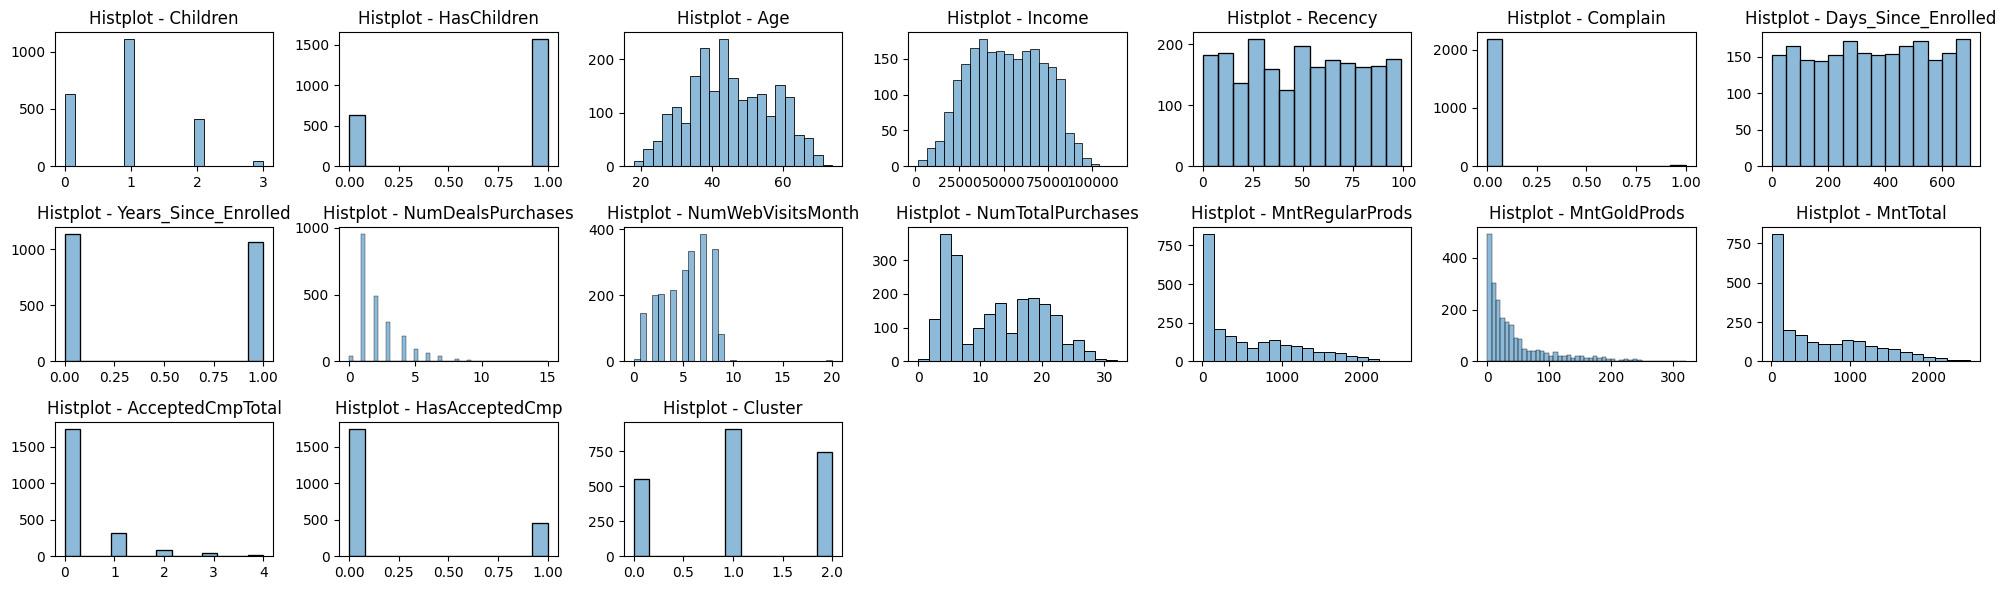

In [11]:
fn_charts.histplots(x, numerical_features, num_cols=7, height_figsize=2) # Criando os histplots para ver sua distribuição

### Definindo por qual procedimento cada feature de x vai passar

In [12]:
one_hot_cols = [ # Definindo as colunas que vão passar por One Hot Encoder
    'Education', # Coluna categórica
    'Marital_Status', # Coluna categórica
    'AgeGroup', # Coluna categórica
    'Children', # Coluna com inteiros discretos
    'HasChildren', # Coluna com inteiros discretos
    'Complain', # Coluna com inteiros discretos
    'Years_Since_Enrolled', # Coluna com inteiros discretos
    'AcceptedCmpTotal', # Coluna com inteiros discretos
    'HasAcceptedCmp', # Coluna com inteiros discretos
    'Cluster', # Coluna com inteiros discretos
]

standard_cols = [ # Definindo as colunas que vão passar por Standard Scaler
    'Income', # Coluna com distribuição semelhante à normal
    'Age', # Coluna com distribuição semelhante à normal
]

power_cols = [ # Definindo as colunas que vão passar por Power Transformation
   'NumDealsPurchases', # Coluna com assimetria dos dados
   'NumWebVisitsMonth', # Coluna com assimetria dos dados
   'NumTotalPurchases', # Coluna com assimetria dos dados
   'MntRegularProds', # Coluna com assimetria dos dados
   'MntGoldProds', # Coluna com assimetria dos dados
   'MntTotal', # Coluna com assimetria dos dados
]

min_max_cols = [ # Definindo as colunas que vão passar por Min-Max Scaler
    'Recency', # Coluna com distribuição uniforme dos dados
    'Days_Since_Enrolled', # Coluna com distribuição uniforme dos dados
]

### Estabelecendo os pré processamentos que serão aplicados nas features antes da otimização de hiperparâmetros

In [13]:
preprocessing_initial = ColumnTransformer( # Estabelecendo os pré processamentos que serão aplicados nas features
    [ # Passando a inicial do novo nome da coluna, o pré processamento que será aplicado e a lista de colunas para pré processamento
        ('one_hot', OneHotEncoder(), one_hot_cols),
        ('standard', StandardScaler(), standard_cols),
        ('min_max', MinMaxScaler(), min_max_cols),
        ('power', PowerTransformer(), power_cols),
    ]
)

### Criando o pipeline para o modelo antes da otimização de hiperparâmetros

In [14]:
pipeline_initial = Pipeline( # Criando o pipeline para o modelo (Pipeline do Imblearn para tratar o desbalanceamento do dataset)
    [ # Passando as etapas do pipeline
        ('pre_processing', preprocessing_initial), # Fazendo o pré processamento conforme as definições anteriores
        ('feature_selection', SelectKBest(score_func=f_classif, k=10)), # Selecionando as melhores features para o modelo 
            # (Obs: nesse caso, não é indicado o uso de PCA pois ocasionaria a perda de features para comunicar os resultados posteriormente)
        ('resampling', RandomUnderSampler(random_state=consts.RANDOM_STATE)), # Tratando o dataset desbalanceado com Random Under Sampler (RUS)
        ('models', LogisticRegression(random_state=consts.RANDOM_STATE)), # Aplicando o modelo passado para a função
    ]
)

### Treinando o modelo com os datasets x e y antes da otimização de hiperparâmetros

In [15]:
pipeline_initial.fit(x, y) # Fazendo o fit do pipeline com o x e o y

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('one_hot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'Children', 'HasChildren',
                                                   'Complain',
                                                   'Years_Since_Enrolled',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Cluster']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('min_max', MinMaxScaler(),
                                                  ['Recency',
                                                   'Days_Since_Enrolled']),
                                                 ('power', PowerTransformer(),
                                                  ['NumDealsPurchases',
                                                   'NumWebVisitsMonth',
                                                   'NumTotalPurchases',
                                                   'MntRegularProds',
                                                   'MntGoldProds',
                                                   'MntTotal'])])),
                ('feature_selection', SelectKBest()),
                ('resampling', RandomUnderSampler(random_state=42)),
                ('models', LogisticRegression(random_state=42))])

### Visualizando as features (colunas) de entrada na etapa de Feature Selection antes da otimização de hiperparâmetros

In [16]:
pipeline_initial[:-3].get_feature_names_out()

array(['one_hot__Education_2n Cycle', 'one_hot__Education_Basic',
       'one_hot__Education_Graduation', 'one_hot__Education_Master',
       'one_hot__Education_PhD', 'one_hot__Marital_Status_Partner',
       'one_hot__Marital_Status_Single', 'one_hot__AgeGroup_18-30',
       'one_hot__AgeGroup_31-45', 'one_hot__AgeGroup_46-60',
       'one_hot__AgeGroup_61+', 'one_hot__Children_0',
       'one_hot__Children_1', 'one_hot__Children_2',
       'one_hot__Children_3', 'one_hot__HasChildren_0',
       'one_hot__HasChildren_1', 'one_hot__Complain_0',
       'one_hot__Complain_1', 'one_hot__Years_Since_Enrolled_0',
       'one_hot__Years_Since_Enrolled_1', 'one_hot__AcceptedCmpTotal_0',
       'one_hot__AcceptedCmpTotal_1', 'one_hot__AcceptedCmpTotal_2',
       'one_hot__AcceptedCmpTotal_3', 'one_hot__AcceptedCmpTotal_4',
       'one_hot__HasAcceptedCmp_0', 'one_hot__HasAcceptedCmp_1',
       'one_hot__Cluster_0', 'one_hot__Cluster_1', 'one_hot__Cluster_2',
       'standard__Income', 'standa

### Visualizando as features (colunas) selecionadas pela etapa de Feature Selection antes da otimização de hiperparâmetros

In [17]:
pipeline_initial[:-1].get_feature_names_out()

array(['one_hot__Children_0', 'one_hot__HasChildren_0',
       'one_hot__HasChildren_1', 'one_hot__AcceptedCmpTotal_0',
       'one_hot__AcceptedCmpTotal_2', 'one_hot__AcceptedCmpTotal_3',
       'one_hot__HasAcceptedCmp_0', 'one_hot__HasAcceptedCmp_1',
       'power__MntRegularProds', 'power__MntTotal'], dtype=object)

### Fazendo o Cross Validate antes da otimização de hiperparâmetros

In [18]:
scores_initial = cross_validate( # Fazendo a validação cruzada para testar diversas combinações de separação entre dados de treino e teste
    pipeline_initial, # Passando o pipeline definido acima
    x, # Definindo o dataset x
    y, # Definindo o dataset y
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=consts.RANDOM_STATE), # Aplicando o StratifiedKFold por ser um dataset desbalanceado
    scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'], # Definindo as métricas de avaliação do modelo
    n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
)

### Criando um dataset com as métricas de avaliação do modelo antes da otimização de hiperparâmetros

In [19]:
scores_initial['time'] = scores_initial['fit_time'] + scores_initial['score_time'] # Criando a coluna de tempo somando fit_time e score_time
scores_initial['results'] = 'initial' # Criando uma coluna para separar os resultados iniciais e finais

df_results_initial = pd.DataFrame(scores_initial) # Criando um df transposto com os resultados dos modelos

df_results_initial # Exibindo o dataset com os resultados iniciais

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time,results
0,0.066952,0.024037,0.784580,0.351064,0.492537,0.725337,0.405243,0.090988,initial
1,0.043091,0.016543,0.775510,0.357143,0.597015,0.771690,0.479887,0.059634,initial
2,0.050107,0.013763,0.807256,0.415094,0.656716,0.798986,0.447234,0.063869,initial
3,0.074597,0.027022,0.791383,0.393443,0.727273,0.842727,0.539000,0.101618,initial
4,0.050643,0.021036,0.736961,0.337662,0.787879,0.832182,0.500177,0.071680,initial


### Visualizando as métricas de avaliação do modelo antes da otimização de hiperparâmetros

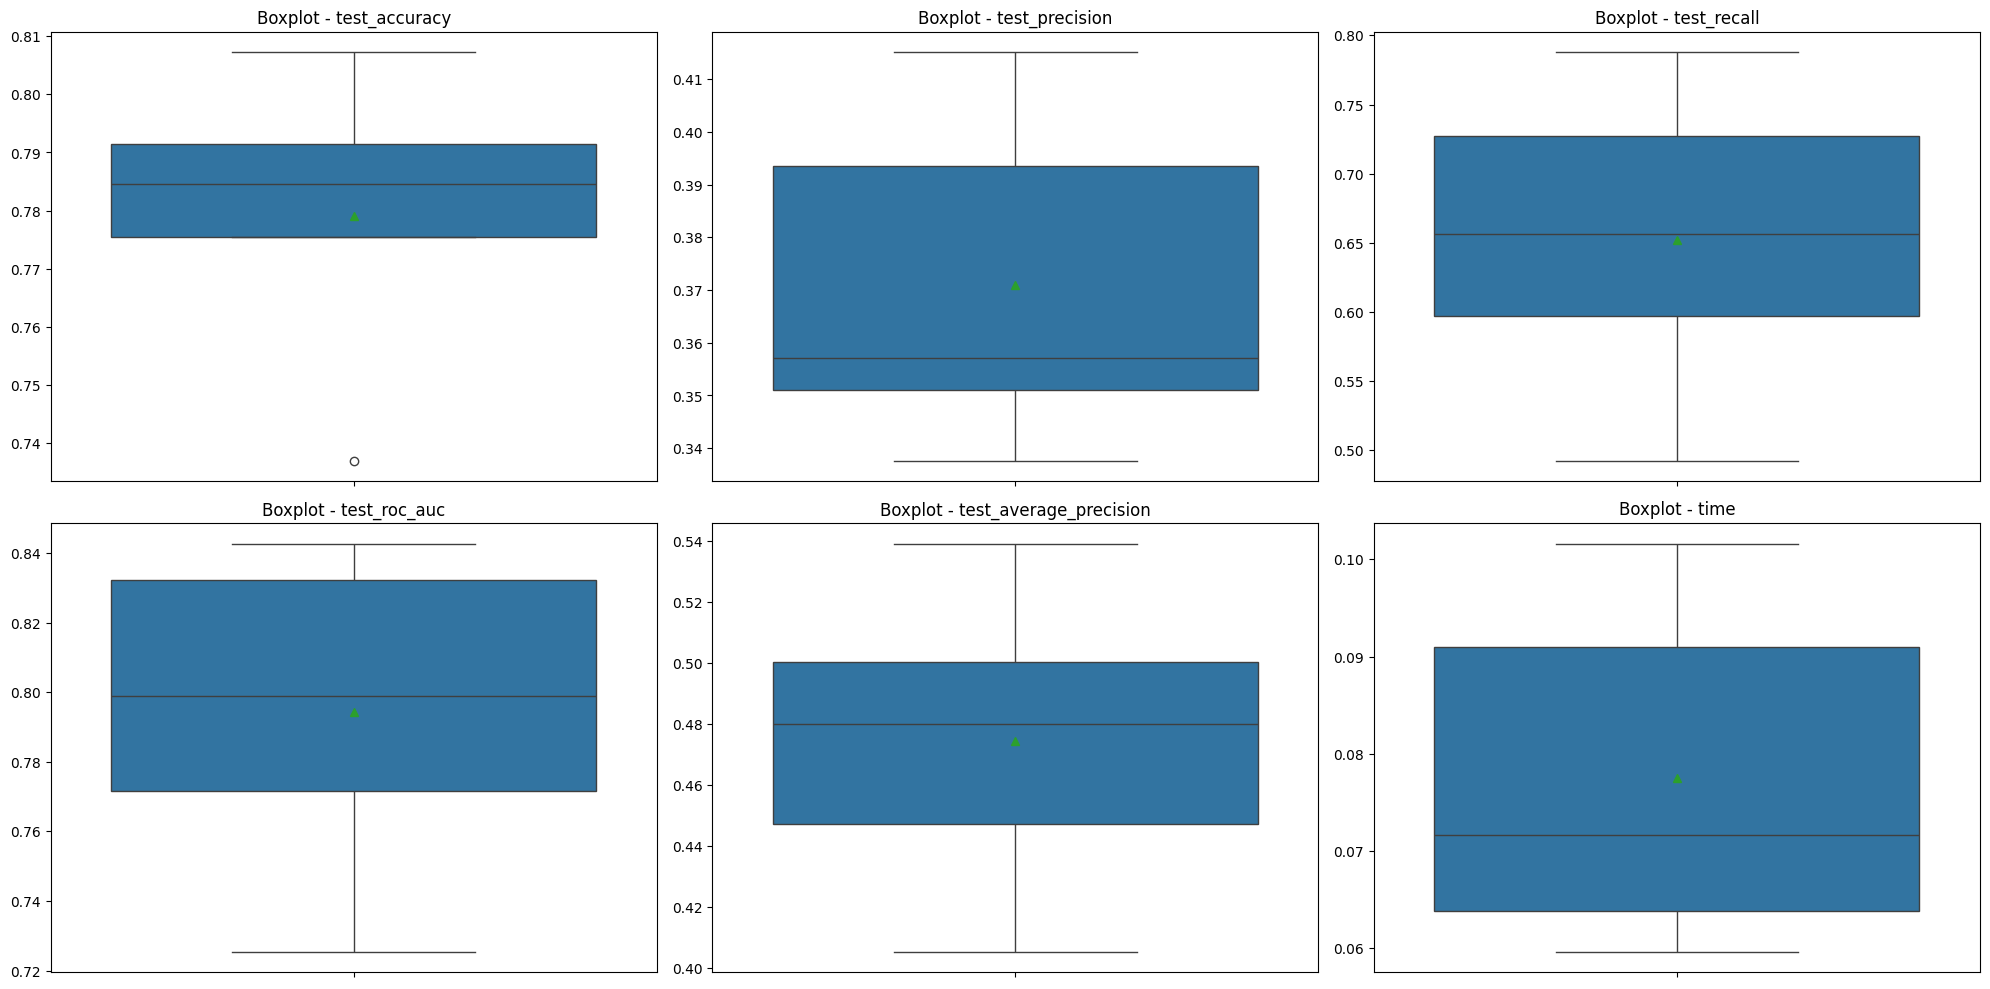

In [20]:
fn_charts.boxplots(df_results_initial, df_results_initial.columns[2:-1].to_list()) # Criando os boxplots para avaliação dos modelos

### Definindo as combinações de parâmetros que serão testados nas etapas do pipeline

In [21]:
params_grid_search = { # Definindo as combinações de parâmetros das etapas do pipeline serão testados (padrão: nome_etapa__parametro)
    'feature_selection__k': [10, 15, 20, 25],
    'models__C': np.logspace(-3, 3, 7),
    'models__solver': ['liblinear', 'lbfgs', 'saga'],
    'models__penalty': ['l1', 'l2', 'elasticnet', 'none'],
}

### Definindo os parâmetros do Grid Search

In [22]:
grid_search = GridSearchCV( # Aplicando o Grid Search
    pipeline_initial, # Definindo o pipeline
    params_grid_search, # Definindo as variações dos parâmetros que serão avaliados
    scoring=['roc_auc', 'average_precision', 'accuracy'], # Definindo as métricas que serão avaliadas
    n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
    refit='average_precision' # Definindo a métrica principal dentre as métricas avaliadas
)

### Treinando o modelo com a otimização de hiperparâmetros com o Grid Search

In [23]:
import warnings # Importando a biblioteca de warnings

warnings.filterwarnings('ignore') # Ignorando os avisos apenas pois há combinações de parâmetros que não podem ser feitas, retornando null

grid_search.fit(x, y) # Fazendo o fit do Grid Search com x e y

GridSearchCV(estimator=Pipeline(steps=[('pre_processing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'AgeGroup',
                                                                          'Children',
                                                                          'HasChildren',
                                                                          'Complain',
                                                                          'Years_Since_Enrolled',
                                                                          'AcceptedCmpTotal',
                                                                          'HasAcceptedCmp',
                                                                          'Cluster']),
                                                                        ('standard',
                                                                         StandardScaler(),
                                                                         ['Income',
                                                                          'Age']),
                                                                        ('min_max',
                                                                         MinMaxScaler(),
                                                                         ['Recency',
                                                                          'D...
                                       ('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-2,
             param_grid={'feature_selection__k': [10, 15, 20, 25],
                         'models__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'models__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'models__solver': ['liblinear', 'lbfgs', 'saga']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

### Visualizando os melhores parâmetros encontrados pelo Grid Search

In [24]:
grid_search.best_params_ # Visualizando os melhores parâmetros encontrados pelo Grid Search

{'feature_selection__k': 25,
 'models__C': 1000.0,
 'models__penalty': 'l2',
 'models__solver': 'saga'}

### Estabelecendo os pré processamentos que serão aplicados nas features com os melhores parâmetros encontrados pelo Grid Search

In [25]:
preprocessing_final = ColumnTransformer( # Estabelecendo os pré processamentos que serão aplicados nas features
    [ # Passando a inicial do novo nome da coluna, o pré processamento que será aplicado e a lista de colunas para pré processamento
        ('one_hot', OneHotEncoder(), one_hot_cols),
        ('standard', StandardScaler(), standard_cols),
        ('min_max', MinMaxScaler(), min_max_cols),
        ('power', PowerTransformer(), power_cols),
    ]
)

### Treinando o modelo com os melhores parâmetros encontrados pelo Grid Search

In [26]:
pipeline_final = Pipeline( # Criando o pipeline para o modelo (Pipeline do Imblearn para tratar o desbalanceamento do dataset)
    [ # Passando as etapas do pipeline
        ('pre_processing', preprocessing_final), # Fazendo o pré processamento conforme as definições anteriores
        ('feature_selection', SelectKBest(score_func=f_classif, k=grid_search.best_params_['feature_selection__k'])), # Selecionando as melhores features para o modelo 
            # (Obs: nesse caso, não é indicado o uso de PCA pois ocasionaria a perda de features para comunicar os resultados posteriormente)
        ('resampling', RandomUnderSampler(random_state=consts.RANDOM_STATE)), # Tratando o dataset desbalanceado com Random Under Sampler (RUS)
        ('models', LogisticRegression(
            random_state=consts.RANDOM_STATE,
            C=grid_search.best_params_['models__C'],
            penalty=grid_search.best_params_['models__penalty'],
            solver=grid_search.best_params_['models__solver'],
        )), # Aplicando o modelo passado para a função
    ]
)

### Treinando o modelo com os datasets x e y após a otimização de hiperparâmetros

In [27]:
pipeline_final.fit(x, y) # Fazendo o fit do pipeline com o x e o y

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('one_hot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'Children', 'HasChildren',
                                                   'Complain',
                                                   'Years_Since_Enrolled',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Cluster']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('min_max', MinMaxScaler(),
                                                  ['Recency',
                                                   'Days_Since_Enrolled']),
                                                 ('power', PowerTransformer(),
                                                  ['NumDealsPurchases',
                                                   'NumWebVisitsMonth',
                                                   'NumTotalPurchases',
                                                   'MntRegularProds',
                                                   'MntGoldProds',
                                                   'MntTotal'])])),
                ('feature_selection', SelectKBest(k=25)),
                ('resampling', RandomUnderSampler(random_state=42)),
                ('models',
                 LogisticRegression(C=1000.0, random_state=42, solver='saga'))])

### Visualizando as features (colunas) selecionadas pela etapa de Feature Selection após a otimização de hiperparâmetros

In [28]:
pipeline_final[:-1].get_feature_names_out()

array(['one_hot__Education_PhD', 'one_hot__Marital_Status_Partner',
       'one_hot__Marital_Status_Single', 'one_hot__Children_0',
       'one_hot__Children_1', 'one_hot__HasChildren_0',
       'one_hot__HasChildren_1', 'one_hot__Years_Since_Enrolled_0',
       'one_hot__Years_Since_Enrolled_1', 'one_hot__AcceptedCmpTotal_0',
       'one_hot__AcceptedCmpTotal_1', 'one_hot__AcceptedCmpTotal_2',
       'one_hot__AcceptedCmpTotal_3', 'one_hot__AcceptedCmpTotal_4',
       'one_hot__HasAcceptedCmp_0', 'one_hot__HasAcceptedCmp_1',
       'one_hot__Cluster_0', 'one_hot__Cluster_1', 'standard__Income',
       'min_max__Recency', 'min_max__Days_Since_Enrolled',
       'power__NumTotalPurchases', 'power__MntRegularProds',
       'power__MntGoldProds', 'power__MntTotal'], dtype=object)

### Fazendo o Cross Validate com os melhores parâmetros encontrados pelo Grid Search

In [29]:
scores_final = cross_validate( # Fazendo a validação cruzada para testar diversas combinações de separação entre dados de treino e teste
    pipeline_final, # Passando o pipeline definido acima
    x, # Definindo o dataset x
    y, # Definindo o dataset y
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=consts.RANDOM_STATE), # Aplicando o StratifiedKFold por ser um dataset desbalanceado
    scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'], # Definindo as métricas de avaliação do modelo
    n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
)

### Criando um dataset com as métricas de avaliação do modelo com os melhores parâmetros encontrados pelo Grid Search

In [30]:
scores_final['time'] = scores_final['fit_time'] + scores_final['score_time'] # Criando a coluna de tempo somando fit_time e score_time
scores_final['results'] = 'final' # Criando uma coluna para separar os resultados iniciais e finais

df_results_final = pd.DataFrame(scores_final) # Criando um df transposto com os resultados dos modelos

df_results_final # Exibindo o dataset com os resultados finais

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time,results
0,0.125565,0.047238,0.791383,0.404580,0.791045,0.882493,0.621708,0.172802,final
1,0.117090,0.052771,0.775510,0.366667,0.656716,0.826363,0.565848,0.169861,final
2,0.129639,0.047232,0.804989,0.430657,0.880597,0.888479,0.590909,0.176872,final
3,0.120076,0.039253,0.804989,0.419355,0.787879,0.879657,0.637658,0.159329,final
4,0.153138,0.031747,0.793651,0.404580,0.803030,0.878404,0.623766,0.184885,final


### Visualizando as métricas de avaliação do modelo com os melhores parâmetros encontrados pelo Grid Search

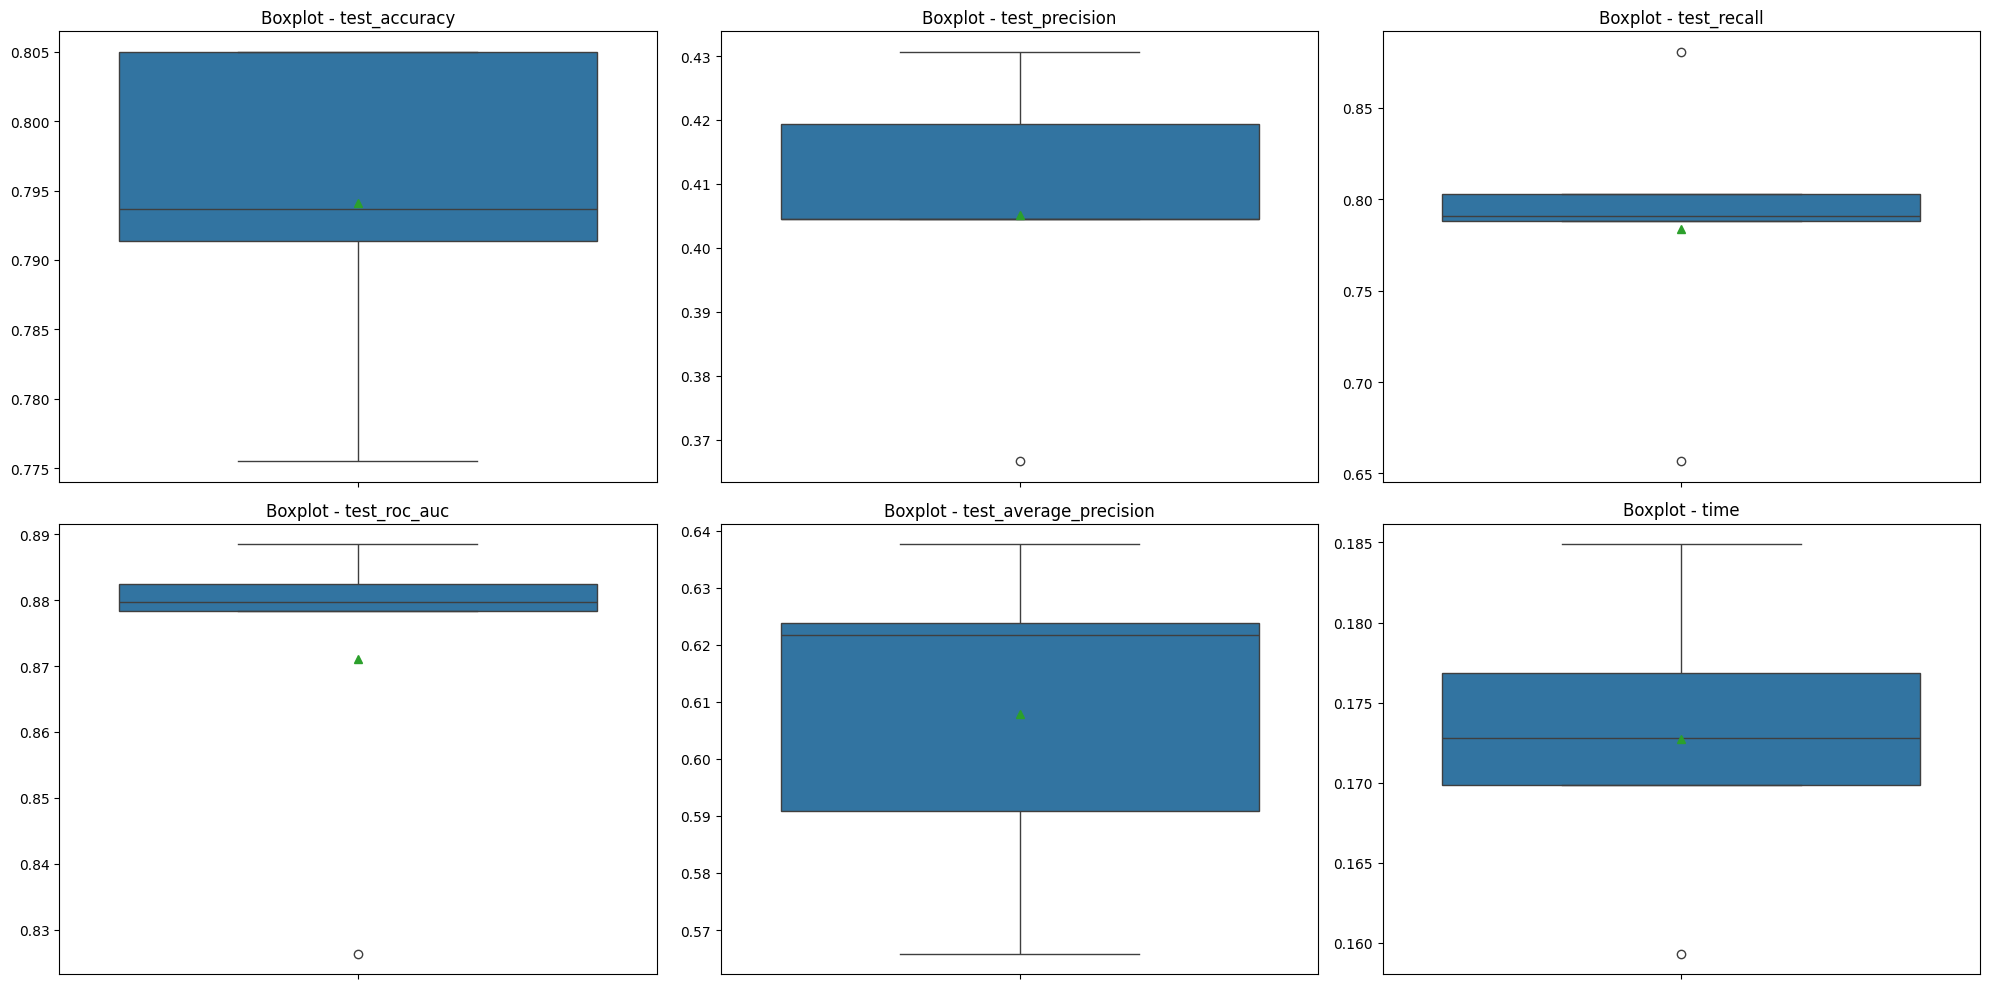

In [31]:
fn_charts.boxplots(df_results_final, df_results_final.columns[2:-1].to_list()) # Criando os boxplots para avaliação dos modelos

### Concatenando os dois datasets de resultados antes e depois para comparar as melhorias da otimização de hiperparâmetros

In [32]:
df_combined = pd.concat([df_results_final, df_results_initial], ignore_index=True) # Concatenando os dois datasets de antes e depois

df_combined # Exibindo o dataset concatenado

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time,results
0,0.125565,0.047238,0.791383,0.404580,0.791045,0.882493,0.621708,0.172802,final
1,0.117090,0.052771,0.775510,0.366667,0.656716,0.826363,0.565848,0.169861,final
2,0.129639,0.047232,0.804989,0.430657,0.880597,0.888479,0.590909,0.176872,final
3,0.120076,0.039253,0.804989,0.419355,0.787879,0.879657,0.637658,0.159329,final
4,0.153138,0.031747,0.793651,0.404580,0.803030,0.878404,0.623766,0.184885,final
5,0.066952,0.024037,0.784580,0.351064,0.492537,0.725337,0.405243,0.090988,initial
6,0.043091,0.016543,0.775510,0.357143,0.597015,0.771690,0.479887,0.059634,initial
7,0.050107,0.013763,0.807256,0.415094,0.656716,0.798986,0.447234,0.063869,initial
8,0.074597,0.027022,0.791383,0.393443,0.727273,0.842727,0.539000,0.101618,initial
9,0.050643,0.021036,0.736961,0.337662,0.787879,0.832182,0.500177,0.071680,initial


### Comparando os resultados de antes e depois da otimização de hiperparâmetros em boxplots

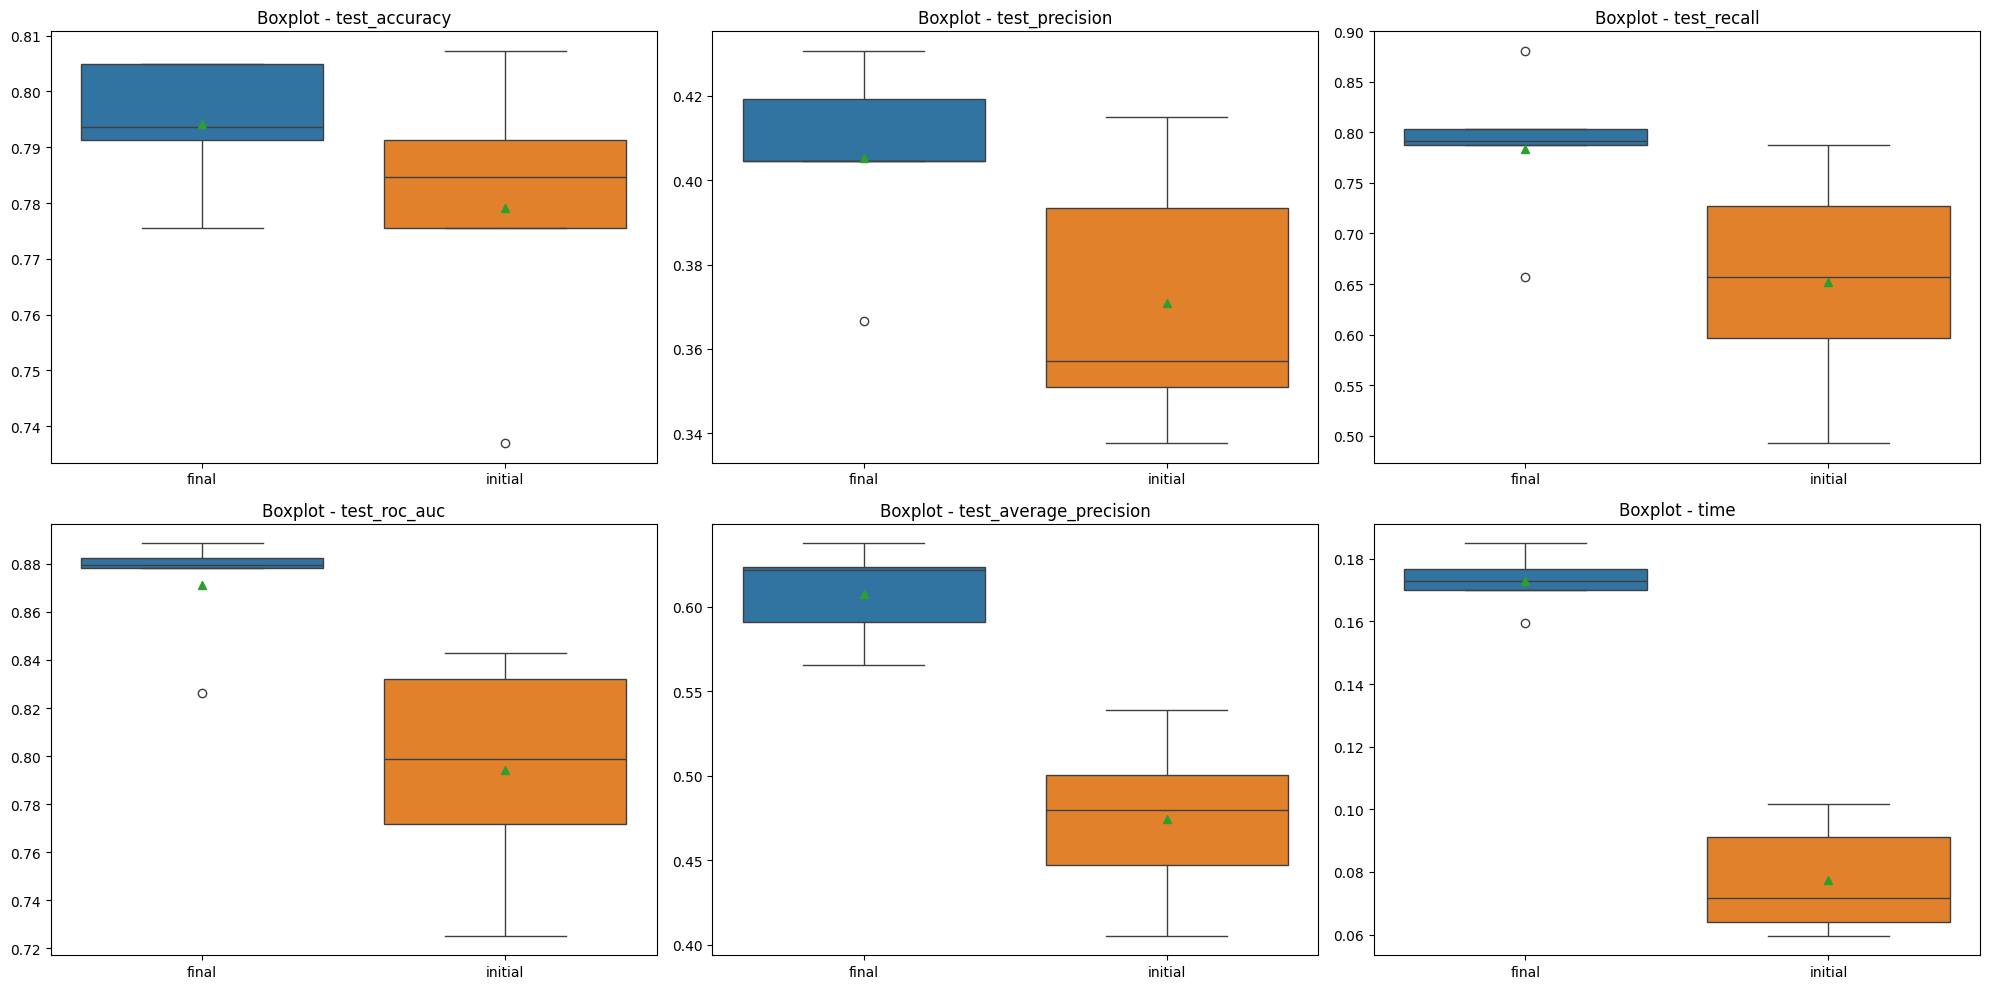

In [33]:
fn_charts.boxplots(df_combined, df_combined.columns[2:-1].to_list(), 'results') # Criando os boxplots para comparação dos modelos

### Salvando o modelo treinado com os melhores parâmetros encontrados pelo Grid Search